In [5]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('../scripts')))
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.express as px

In [6]:
import warnings
warnings.filterwarnings('ignore')


In [7]:
import numpy as np
import pandas as pd
from helper import TelecomHelper
import plots
from clean_telecom_df import CleanTelecomData

pd.options.display.float_format = "{:.6f}".format

In [8]:
CSV_PATH = "../data/cleaned_data.csv"

In [9]:
TelecomHelper = TelecomHelper()

In [14]:
df['msisdn/number'] = df['msisdn/number'].astype("category")
df['handset_type'] = df['handset_type'].astype("category")
cleaned_df = df

In [15]:
experience_df = cleaned_df[['msisdn/number', 'avg_rtt_dl_(ms)', 'avg_rtt_ul_(ms)', 
           'avg_bearer_tp_dl_(kbps)', 'avg_bearer_tp_ul_(kbps)',
           'tcp_ul_retrans._vol_(bytes)', 'tcp_dl_retrans._vol_(bytes)',
           'handset_type']]

experience_df.head()

,msisdn/number,avg_rtt_dl_(ms),avg_rtt_ul_(ms),avg_bearer_tp_dl_(kbps),avg_bearer_tp_ul_(kbps),tcp_ul_retrans._vol_(bytes),tcp_dl_retrans._vol_(bytes),handset_type
0,33664962239.000000,42.000000,5.000000,23.000000,44.000000,772902.274842,21052378.161588,Samsung Galaxy A5 Sm-A520F
1,33681854413.000000,65.000000,5.000000,16.000000,26.000000,772902.274842,21052378.161588,Samsung Galaxy J5 (Sm-J530)
2,33760627129.000000,105.959783,17.633655,6.000000,9.000000,772902.274842,21052378.161588,Samsung Galaxy A8 (2018)
3,33750343200.000000,105.959783,17.633655,44.000000,44.000000,772902.274842,21052378.161588,Samsung Galaxy A8 (2018)
4,33699795932.000000,105.959783,17.633655,6.000000,9.000000,772902.274842,21052378.161588,Samsung Sm-G390F


In [16]:
def handle_outliers(df, col, method="lower_upper"):
    df = df.copy()
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    
    lower_bound = q1 - ((1.5) * (q3 - q1))
    upper_bound = q3 + ((1.5) * (q3 - q1))
    
    if method == "mean":
        df[col] = np.where(df[col] < lower_bound,   df[col].mean(), df[col])
        df[col] = np.where(df[col] > upper_bound, df[col].mean(), df[col])
    
    elif  method == "mode":
        df[col] = np.where(df[col] < lower_bound,   df[col].mode()[0], df[col])
        df[col] = np.where(df[col] > upper_bound, df[col].mode()[0], df[col])
    else:
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    
    return df

In [17]:

cleaned_experience_df = handle_outliers(experience_df, 'avg_rtt_dl_(ms)', method="mean")
cleaned_experience_df = handle_outliers(experience_df, 'avg_rtt_ul_(ms)', method="mean")

cleaned_experience_df = handle_outliers(experience_df, 'avg_bearer_tp_dl_(kbps)', method="mean")
cleaned_experience_df = handle_outliers(experience_df, 'avg_bearer_tp_ul_(kbps)', method="mean")

cleaned_experience_df = handle_outliers(experience_df, 'tcp_ul_retrans._vol_(bytes)', method="mean")
cleaned_experience_df = handle_outliers(experience_df, 'tcp_dl_retrans._vol_(bytes)', method="mean")



In [18]:

experience_metrics_df = pd.DataFrame(columns=['msisdn', 'handset_type', 'avg_rtt_ms',
                                              'avg_throughput_kbps', 'tcp_retrans_bytes'])

experience_metrics_df['avg_rtt_ms'] = cleaned_experience_df['avg_rtt_dl_(ms)'] + cleaned_experience_df['avg_rtt_ul_(ms)']
experience_metrics_df['avg_throughput_kbps'] = cleaned_experience_df['avg_bearer_tp_dl_(kbps)'] + cleaned_experience_df['avg_bearer_tp_ul_(kbps)']
experience_metrics_df['tcp_retrans_bytes'] = cleaned_experience_df['tcp_ul_retrans._vol_(bytes)'] + cleaned_experience_df['tcp_dl_retrans._vol_(bytes)']

experience_metrics_df['msisdn'] = cleaned_experience_df['msisdn/number']
experience_metrics_df['handset_type'] = cleaned_experience_df['handset_type']



In [19]:
experience_metrics_df.head()

,msisdn,handset_type,avg_rtt_ms,avg_throughput_kbps,tcp_retrans_bytes
0,33664962239.000000,Samsung Galaxy A5 Sm-A520F,47.000000,67.000000,21825280.436430
1,33681854413.000000,Samsung Galaxy J5 (Sm-J530),70.000000,42.000000,21825280.436430
2,33760627129.000000,Samsung Galaxy A8 (2018),123.593439,15.000000,21825280.436430
3,33750343200.000000,Samsung Galaxy A8 (2018),123.593439,88.000000,21825280.436430
4,33699795932.000000,Samsung Sm-G390F,123.593439,15.000000,21825280.436430


In [20]:
experience_metrics_df.describe()

,avg_rtt_ms,avg_throughput_kbps,tcp_retrans_bytes
count,146891.000000,146891.000000,146891.000000
mean,123.593439,15207.646609,14881528.730508
std,537.295718,26952.835523,18781257.656052
min,0.000000,0.000000,86.000000
25%,40.000000,90.000000,1521045.000000
50%,66.000000,126.000000,21825280.436430
75%,123.593439,22702.500000,21825280.436430
max,96924.000000,382262.000000,2913408387.000000


In [21]:

experience_agg_by_customer = experience_metrics_df.groupby('msisdn').agg({'avg_rtt_ms': 'sum',
                                                                          'avg_throughput_kbps': 'sum',
                                                                          'tcp_retrans_bytes': 'sum', 
                                                                           'handset_type': lambda x: x.mode()[0]})

In [22]:
experience_agg_by_customer.head()

,avg_rtt_ms,avg_throughput_kbps,tcp_retrans_bytes,handset_type
msisdn,,,,
33601001722.0,46.000000,76.000000,21825280.436430,Huawei P20 Lite Huawei Nova 3E
33601001754.0,31.000000,99.000000,21825280.436430,Apple iPhone 7 (A1778)
33601002511.0,123.593439,97.000000,21825280.436430,Apple iPhone 7 Plus (A1784)
33601007832.0,84.000000,248.000000,773968.274842,Apple iPhone 5S (A1457)
33601008617.0,119.000000,56844.000000,31196112.436430,Apple iPhone Se (A1723)


### Task 3.2

10 of the top, bottom and most frequent:
TCP values in the dataset.


In [23]:

tcp_trans = experience_agg_by_customer.sort_values(by=['tcp_retrans_bytes'], ascending=False)

top_10_tcp = tcp_trans.head(10)
bot_10_tcp = tcp_trans.tail(10)
most_tcp_frq = tcp_trans['tcp_retrans_bytes'].value_counts().head(10)


In [24]:
top_10_tcp[['tcp_retrans_bytes']]

,tcp_retrans_bytes
msisdn,
33669054076.0,5196040244.436430
33658249284.0,2676347975.000000
33763588772.0,2464813763.000000
33664698321.0,1772435895.161588
33665090461.0,1748862378.161588
33760918898.0,1261786243.436430
33668333080.0,873674425.484766
33661679531.0,794947990.000000
33698382849.0,740624185.161588


In [25]:
bot_10_tcp[['tcp_retrans_bytes']]

,tcp_retrans_bytes
msisdn,
33699694715.0,182.000000
33679366089.0,179.000000
33784203839.0,177.000000
33769636458.0,176.000000
33650681239.0,176.000000
33607833304.0,143.000000
33626357513.0,134.000000
33762062356.0,129.000000
33614777138.0,128.000000


In [26]:
most_tcp_frq

21825280.436430    46756
43650560.872860     7367
65475841.309290     1013
21053672.161588      363
87301121.745720      238
21053708.161588      162
774232.274842        145
42878952.598019       82
21053696.161588       81
772994.274842         76
Name: tcp_retrans_bytes, dtype: int64

10 of the top, bottom and most frequent:
RTT values in the dataset.

In [27]:
tcp_rtt = experience_agg_by_customer.sort_values(by=['avg_rtt_ms'], ascending=False)

top_10_rtt = tcp_rtt.head(10)
bot_10_rtt = tcp_rtt.tail(10)
most_rtt_frq = tcp_rtt['avg_rtt_ms'].value_counts().head(10)


In [28]:
top_10_rtt[['avg_rtt_ms']]

,avg_rtt_ms
msisdn,
33662317023.0,96924.000000
33660874265.0,64670.000000
33683692867.0,54848.000000
33698551167.0,46021.000000
33761813523.0,37084.000000
33668791629.0,36304.000000
33760941100.0,27278.000000
33606788933.0,26300.000000
33671816754.0,25715.000000


In [29]:
bot_10_rtt[['avg_rtt_ms']]

,avg_rtt_ms
msisdn,
33634684770.0,10.000000
33672196893.0,9.000000
33610846366.0,9.000000
33647679481.0,8.000000
33668619895.0,6.000000
33659493541.0,5.000000
33695045499.0,4.000000
33660204450.0,2.000000
33652982188.0,0.000000


In [30]:
most_rtt_frq

123.593439    15770
29.000000      2735
39.000000      2170
247.186877     1863
38.000000      1450
30.000000      1423
40.000000      1387
28.000000      1332
49.000000      1194
31.000000      1053
Name: avg_rtt_ms, dtype: int64

10 of the top, bottom and most frequent:
tcp throuput in the dataset.

In [35]:

tcp_throuput = experience_agg_by_customer.sort_values(by=['avg_throughput_kbps'], ascending=False)

top_10_throuput = tcp_throuput.head(10)
bot_10_throuput = tcp_throuput.tail(10)
most_rtt_throuput = tcp_throuput['avg_throughput_kbps'].value_counts().head(10)



In [32]:
top_10_throuput[['avg_throughput_kbps']]

,avg_throughput_kbps
msisdn,
33762333464.0,902222.000000
33668708263.0,840424.000000
33659546392.0,798342.000000
33669946573.0,690815.000000
33668425947.0,676858.000000
33698174760.0,618795.000000
33625700673.0,564179.000000
33658075438.0,550352.000000
33762644658.0,549661.000000


In [36]:
bot_10_throuput[['avg_throughput_kbps']]

,avg_throughput_kbps
msisdn,
33782806278.0,0.000000
33667336746.0,0.000000
33634247429.0,0.000000
33659471143.0,0.000000
33662540046.0,0.000000
33608514832.0,0.000000
33761309821.0,0.000000
33662203388.0,0.000000
33667414355.0,0.000000


In [37]:
most_rtt_throuput

15.000000    2688
63.000000    2073
97.000000    1024
90.000000    1006
98.000000     969
96.000000     865
99.000000     852
89.000000     815
95.000000     798
91.000000     792
Name: avg_throughput_kbps, dtype: int64

#### Task 3.3

The distribution of the average throughput  per handset type and provide interpretation for your findings.


In [38]:

handset_agg = experience_agg_by_customer.groupby('handset_type').agg({'avg_throughput_kbps': 'sum',
                                                                       'tcp_retrans_bytes': 'sum'})
handset_agg.head()


,avg_throughput_kbps,tcp_retrans_bytes
handset_type,,
A-Link Telecom I. Cubot A5,23510.000000,21825280.436430
A-Link Telecom I. Cubot Note Plus,6699.000000,616213.000000
A-Link Telecom I. Cubot Note S,8937.000000,41411731.000000
A-Link Telecom I. Cubot Nova,56217.000000,137170.000000
A-Link Telecom I. Cubot Power,69468.000000,8041.000000


the distribution of the average throughput  per handset type 

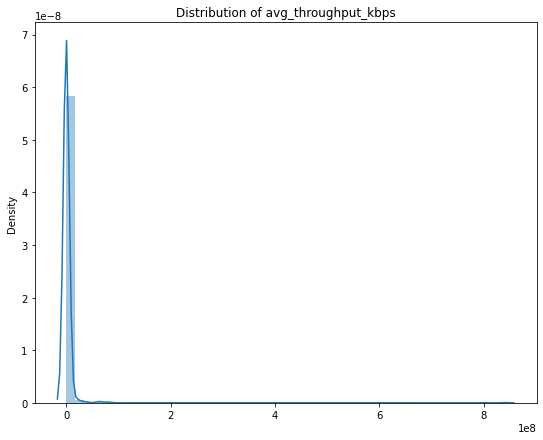

,avg_throughput_kbps,tcp_retrans_bytes
count,1362.000000,1362.000000
mean,1640136.870778,1604965225.222569
std,23571033.603232,11499284145.934683
min,0.000000,360.000000
25%,3413.250000,1381438.250000
50%,26397.500000,21825280.436430
75%,113352.500000,69388028.647028
max,840788249.000000,213982393484.102264


In [40]:


plots.plot_dist(handset_agg[['avg_throughput_kbps']], 'avg_throughput_kbps')
handset_agg.describe()


The distribution of the average average TCP retransmission view per handset type

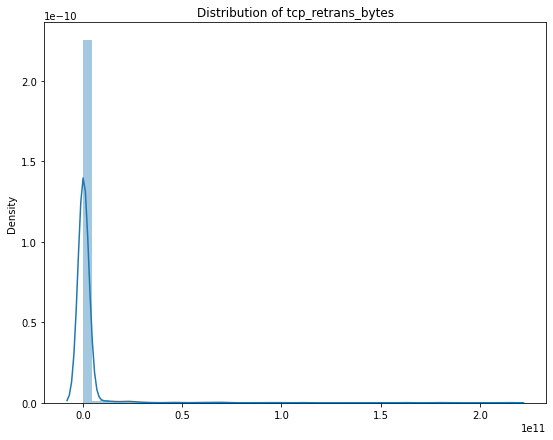

In [42]:

plots.plot_dist(handset_agg[['tcp_retrans_bytes']], 'tcp_retrans_bytes')


### Task 3.4

Using the experience metrics above, perform a k-means clustering (where k = 3) to segment users into groups of experiences 

In [44]:
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.cluster import KMeans


def normalizer(df, columns):
    norm = Normalizer()
    return pd.DataFrame(norm.fit_transform(df), columns=columns)

def scaler(df, columns):
    minmax_scaler = MinMaxScaler()
    return pd.DataFrame(minmax_scaler.fit_transform(df), columns=columns)

def scale_and_normalize(df,columns ):
    return normalizer(scaler(df, columns), columns)

In [45]:
def cluser_label(x: int, cols: list = []) -> str:
    if (not type(x) == int):
        return x
    if (x < len(cols)):
        return cols[x]

    return str(x)

Normalization

In [46]:

metrics = experience_agg_by_customer[['avg_rtt_ms', 'avg_throughput_kbps', 'tcp_retrans_bytes']]
normalized_metrics = scale_and_normalize(metrics, ['avg_rtt_ms', 'avg_throughput_kbps', 'tcp_retrans_bytes'])
normalized_metrics.describe()


,avg_rtt_ms,avg_throughput_kbps,tcp_retrans_bytes
count,105719.000000,105719.000000,105719.000000
mean,0.163503,0.443765,0.566023
std,0.195578,0.461894,0.452067
min,0.000000,0.000000,0.000000
25%,0.040538,0.023949,0.038511
50%,0.094815,0.054940,0.956297
75%,0.290303,0.995659,0.990590
max,1.000000,0.999999,0.999749


In [52]:
kmeans = KMeans(n_clusters=3, init='k-means++').fit(normalized_metrics)
pred = kmeans.predict(normalized_metrics)

experience_metrics_with_cluster = experience_agg_by_customer.copy()
experience_metrics_with_cluster['clusters'] = pred
experience_metrics_with_cluster['clusters'].value_counts()

0    57284
1    43686
2     4749
Name: clusters, dtype: int64

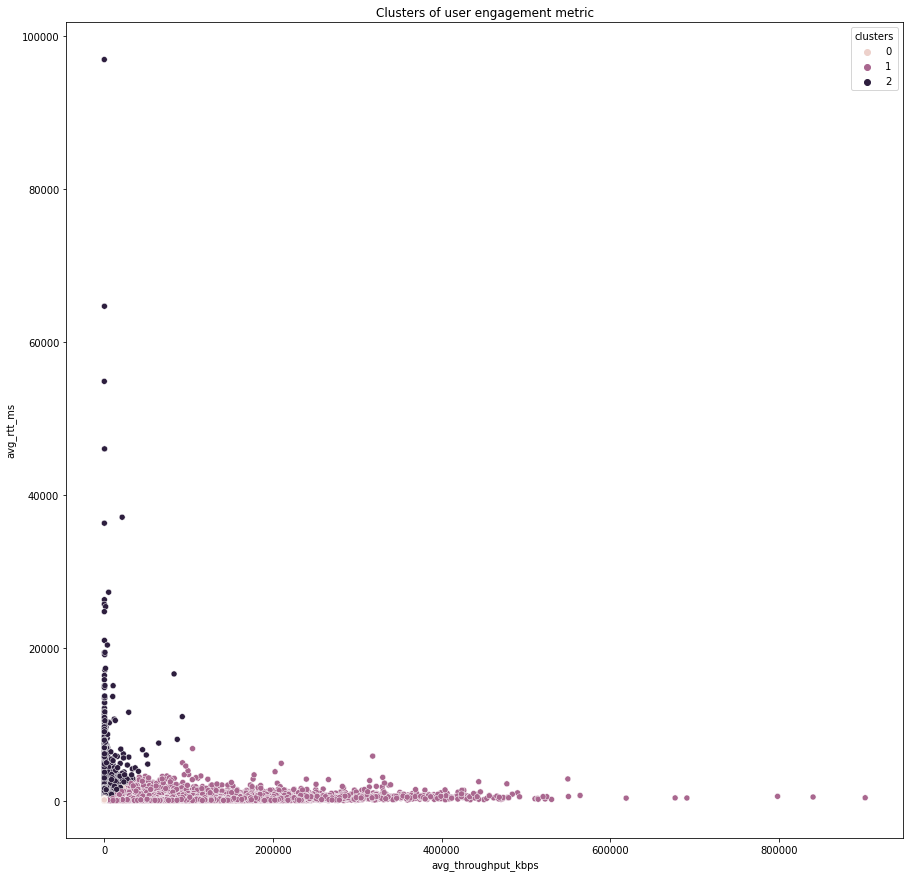

In [53]:
# labels = ['cluser_1', 'cluser_2', 'cluser_3']

# experience_metrics_with_cluster['clusters']  = experience_metrics_with_cluster['clusters'].map(lambda x:
#                                                                                              cluser_label(x, labels))

plt.figure(figsize=(15,15))

sns.scatterplot(x = 'avg_throughput_kbps', y='avg_rtt_ms',
                hue='clusters', data=experience_metrics_with_cluster).set_title('Clusters of user engagement metric')

plt.show()


#### Saving user expiernce metrics

In [50]:
TelecomHelper.save_csv(experience_metrics_with_cluster, '../data/user_experience_metrics.csv')

File Successfully Saved.!!!


,avg_rtt_ms,avg_throughput_kbps,tcp_retrans_bytes,handset_type,clusters
msisdn,,,,,
33601001722.0,46.000000,76.000000,21825280.436430,Huawei P20 Lite Huawei Nova 3E,cluser_1
33601001754.0,31.000000,99.000000,21825280.436430,Apple iPhone 7 (A1778),cluser_1
33601002511.0,123.593439,97.000000,21825280.436430,Apple iPhone 7 Plus (A1784),cluser_1
33601007832.0,84.000000,248.000000,773968.274842,Apple iPhone 5S (A1457),cluser_3
33601008617.0,119.000000,56844.000000,31196112.436430,Apple iPhone Se (A1723),cluser_2
...,...,...,...,...,...
33789967113.0,53.000000,67.000000,21825280.436430,Apple iPhone 6S (A1688),cluser_1
33789980299.0,192.593439,163079.000000,21835376.436430,Apple iPhone 7 Plus (A1784),cluser_2
33789996170.0,52.000000,10365.000000,218045.000000,Huawei Honor 9 Lite,cluser_2


### Task 4.1 B

experience score to each user

In [59]:
experience_metrics_with_cluster_2 = experience_metrics_with_cluster.copy()
experience_metrics_with_cluster_2 = experience_metrics_with_cluster_2.drop('handset_type', axis=1)
kmeans

KMeans(n_clusters=3)

In [62]:
distance = kmeans.fit_transform(experience_metrics_with_cluster_2)

distance_from_less_exp = list(map(lambda x : x[1], distance))

distance_from_less_exp
experience_metrics_with_cluster_2['score'] = distance_from_less_exp

NameError: name 'distance_from_less_engagement' is not defined